<H1>Descente de gradient</H1>  

La descente de gradient (*Gradient Descent*) est un algorithme d'optimisation qui permet de rechercher le minimum d'une fonction (minimiser une fonction) qui est différentiable (dont on peut calculer la dérivée) définie sur un espace Euclidien (par exemple $\mathbb{R}^n$). Ce n'est pas un concept nouveau, il a été inventé par un mathématicien Français, <a href="https://www.math.uni-bielefeld.de/documenta/vol-ismp/40_lemarechal-claude.pdf">Louis Augustin Cauchy</a> en 1847. Il est par contre d'un grand intérêt aujourd'hui notamment pour l'entrainement des réseaux profonds (deep learning).

Dans la suite de ce notebook, nous nous intéressons plus particulièrement à l'apprentissage supervisé.

## Installation



Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.


In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

# sous Colab il faut déjà intégrer ces deux librairies

#!pip install ...


# eventuellement ne pas oublier de relancer le kernel du notebook

In [ ]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn import preprocessing

from sklearn import linear_model
# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten



Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [ ]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive :

In [ ]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024


'/content/gdrive/My Drive/Colab Notebooks/ML2_2023_2024'

## Cas de la régression linéaire

De manière à mieux comprendre le concept de descente de gradient, considérons un jeu de données aléatoire pour lequel nous savons que la fonction linéaire pour le créer initialement est $y=4x+5$.

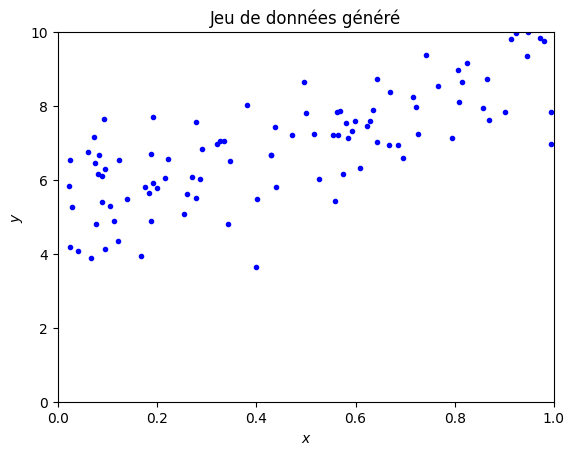

In [ ]:

#definition de la fonction y=f(4X + 5)
X = np.random.rand(100,1)
y = 5 + 4*X+np.random.randn(100,1)
#X = 2 * np.random.rand(100,1)
#y = 4 +3 * X+np.random.randn(100,1)
#Visualisation du jeu de données
plt.plot(X,y,'b.')
plt.title('Jeu de données généré')
plt.xlabel("$x$", fontsize=10)
plt.ylabel("$y$", fontsize=10)
#plt.plot(X,4*X+ 5,'r-')
plt.axis([0,1,0,10])
plt.show()

Actuellement nous connaissons plus ou moins l'équation de la droite (des valeurs aléatoires ont été ajoutées) mais l'objectif d'un algorithme d'apprentissage est, à partir d'un ensemble connu d'apprentissage de pouvoir prédire les valeurs de nouvelles entrées. En d'autres termes, nous souhaitons construire un modèle : une hypothèse qui peut être utilisé pour estimer $y$ en fonction de $x$.

Nous savons que notre hypothèse à trouver est de la forme :  

$$h_\theta(x) =\theta_0 + \theta_1x$$  

où $\theta_0$ correspond au point d'intersection avec l'axe des $y$ et  $\theta_1$ à la pente de la droite.  

<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/droitetheta.png" width="450" height="300">
</center>
Considérons la fonction predict suivante et initialisons $\theta_0=2$ et $\theta_1 =1$ :

In [ ]:
def predict(X, theta0, theta1):
    return theta0 + theta1*X

print ('Valeur de X[5] : ',X[5],' - valeur réelle de y[5] : ',y[5])
theta0=2
theta1=1
print ('valeur prédite : ',predict(X[5], theta0, theta1))

Valeur de X[5] :  [0.08896109]  - valeur réelle de y[5] :  [5.4147464]
valeur prédite :  [2.08896109]


Nous pouvons constater que la valeur prédite est loin de la valeur réelle.


L’objectif est donc de déterminer les valeurs de $\theta_0$ et $\theta_1$, de sorte que l'erreur soit la plus faible possible.

La fonction de coût (*Cost Function*) ou de perte (*Loss Function*) permet d’évaluer les erreurs de prédiction. La fonction de coût calcule l'erreur pour une seule occurrence d’apprentissage, tandis que la fonction de perte est la moyenne des fonctions de coûts pour tous les exemples d’apprentissage. Par abus de langage, les deux sont utilisés.   

Si nous avons $m$ données dans l'ensemble d'apprentissage, nous souhaitons minimiser l'erreur. Une fonction de coût souvent utilisée est l'erreur quadratique moyenne (*Mean square error (MSE) https://en.wikipedia.org/wiki/Mean_squared_error)* :

$$J=\frac{1}{m}\sum_{i=1}^{m}(ŷ^{(i)}-y^{(i)})^2$$  

*Remarque* : les différences quadratiques sont préférées aux différences absolues car elles permettent de trouver une ligne de régression en calculant la dérivée première. En outre le fait de mettre au carré augmente la distance d'erreur ce qui met en évidence les mauvaises prédictions.

Dans notre cas, $J$ dépend de $\theta_0$ et $\theta_1$ donc :
$$J(\theta_0,\theta_1)=\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})^2$$
$$=\frac{1}{m}\sum_{i=1}^{m}((\theta_0+\theta_1x^{(i)})-y^{(i)})^2$$



**Comment minimiser la fonction de coût ?**  

En fait si nous regardons $J$ elle est de type : $y=x^2$. Nous pouvons la dessiner et le minimum est situé à la position (0,0) (point rouge sur le dessin).
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/xaucaree.png" style="width: 400px;">
</center>

Pour minimiser la fonction il faut trouver la valeur de $x$ qui produit la valeur de $y$ la plus basse. Pour cela on utilise l'algorithme de descente de gradient.

**Algorithme de Descente de Gradient** (*Gradient Descent*)  

La descente de gradient est un algorithme, très utilisé en apprentissage, itératif d'optimisation pour trouver le minimum d'une fonction, i.e. dans notre cas la fonction de perte.


Un exemple classique pour expliquer l’approche est la suivante. Considéreons une personne sur une montage avec les yeux bandés qui souhaite descendre dans la plaine. La seule aide dont dispose la personne est l'altitude qu'elle peut relever. La personne peut commencer à descendre dans une direction aléatoire puis regarer l'altitude. Si elle est supérieure à l'altitude initiale, elle sait qu'elle est dans la mauvaise direction. Elle peut alors changer  de direction et répêter le même processus. De la même manière elle peut marcher plus ou moins vite en fonction de la pente. Si la pente est raide elle descend vite et autrement plus lentement. Au bout de beaucoup d'itérations elle arrive au creux de la vallée.   

Dans notre cas, les gradients indiquent la direction, l'altitude est indiquée par $J(\theta_0,\theta_1)$ et les pas sont indiqués par le taux d'apprentissage (*Learning rate*).  

Pour un point donné, la valeur de du gradient (la dérivée) correspond à l’inclinaison de la pente en ce point. La figure suivante illustre la tangente de deux points. Nous pouvons constater que la pente pour le point vert est plus faible que pour le point bleu. Cela indique qu'il y a moins de pas à faire pour atteindre le minimum. Ainsi si le gradient est élevé, c’est que la pente est très pentue, s'il est faible, la pente est faible. S'il est égal à zéro il s'agit d'un minimum. Enfin s'il est négatif cela veut dire que la pente descend (dans ce cas il faut poursuivre dans cette direction) et autrement elle monte (il faut partir dans l'autre direction).
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/tangente.png" width="400" height="260">
</center>


Le point bleu, dans la figure suivante, est situé à la position $x=-4.5$. Nous savons que la fonction de coût est : $y=f(x^2$), i.e. $y=f(-4.5^2)=20.25$. La dérivée de $f$ est : $f’=2x$ donc nous avons : $f’(2 \times -4.5) = -9$. Le $-9$ indique qu'il s'agit d'une pente forte et le fait que le nombre soit négatif indique qu'il faut continuer à se déplacer dans cette direction.  

<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/gradientnextpoint.png" width="400" height="260">
</center>
Pour résumer le gradient, i.e. la pente de la fonction de coût pour un point donné, représente la direction et le taux de variation de la fonction de coût. Suivre le gradient négatif de la fonction  permet donc de la minimiser le plus rapidement possible.

Le pas pour atteindre le minimum s'appelle le taux d'apprentissage (*learning rate*) et est souvent noté $\eta$.
Plus ce pas est petit plus il faudra du temps pour atteindre le point le plus bas. D'un autre côté un pas trop élevé risque de nous faire dépasser le minimum. Généralement les valeurs de $\eta$ sont comprises entre 0.0001 et 1.

Le site suivant propose une application pour tester et visualiser les impacts d'un choix d'$\eta$ :  
https://developers.google.com/machine-learning/crash-course/fitter/graph.  
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/tauxapprentissage.png"  width="450" height="300">
</center>

Il est très difficile de choisir la bonne valeur et de nombreuses expériences sont souvent nécessaires.
Nous pouvons couvrir plus de domaines avec des pas plus importants (taux d'apprentissage élevé), mais nous courons le risque de dépasser les minima. D'un autre côté, les petits pas (petit taux d'apprentissage) prendront beaucoup de temps pour atteindre le point le plus bas.

Concrétement voici à quoi cela correspond. Si le vecteur des paramètres est $\theta = [\theta_0, \theta_1]$ et que les changements désirés sont $\Delta\theta = [\Delta\theta_0, \Delta\theta_1]$
alors la nouvelle position correspond à $\theta_{new}= \theta_{old} + \eta\times\Delta\theta_{old}$.
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/vecteurthetanew.png"  width="400" height="200">
</center>

**Petit rappel sur les dérivées partielles**  


Nous savons que notre fonction de perte est :  

$$J(\theta_0,\theta_1)=\frac{1}{m}\sum_{i=1}^{m}((\theta_0+\theta_1x^{(i)})-y^{(i)})^2$$  


Le gradient est le vecteur des dérivées partielles selon chaque dimension. Donc pour  calculer la descente de gradient il est  nécessaire de calculer les dérivées partielles par rapport à $\theta_0$ et $\theta_1$ pour savoir dans quelle direction aller.  

Une dérivée partielle d'une fonction de plusieurs variables, ici $J(\theta)$, est la dérivée de cette fonction selon une variable, les autres étant considérées constantes. Considérons le point positionné sur la figure suivante. Dans (a), nous fixons $\theta_1$ comme constante et nous pouvons donc calculer la dérivée partielle $\frac{\partial J(\theta_0,\theta_1)}{\partial \theta_0}$. Dans notre exemple, le point est positionné en descente le sens du vecteur est donc vers les valeurs négatives. Dans (b), en fixant $\theta_0$ comme constante, nous pouvons calculer la dérivée partielle $\frac{\partial J(\theta_0,\theta_1)}{\partial \theta_1}$ et là aussi comme le point est sur une pente, le sens du vecteur est orienté vers des valeurs négatives. Dans (c), il suffit de faire la somme des deux vecteurs précédents et le vecteur résultat est indiqué dans (d).
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/rappelderiveespartielles.png"  width="600" height="350">
</center>
Ainsi, à partir de :

$$J(\theta_0,\theta_1)=\frac{1}{m}\sum_{i=1}^{m}((\theta_0+\theta_1x^{(i)})-y^{(i)})^2$$

les dérivées partielles par rapport à $\theta_0$ et $\theta_1$ :   

$$\frac{\partial J(\theta_0,\theta_1)}{\partial \theta_1} = \frac{-2}{m} \sum_{i=1}^m ((\theta_0+\theta_1x^{(i)})-y^{(i)})x^{(i)} $$  
et  

$$\frac{\partial J(\theta_0,\theta_1)}{\partial \theta_0} = \frac{-2}{m} \sum_{i=1}^m ((\theta_0+\theta_1x^{(i)})-y^{(i)}) $$

L'algorithme de descente de gradient consiste donc à déplacer $\theta_0$ et $\theta_1$ jusquà atteindre un minimum pour la fonction de coût :  

$$\begin {array} {lc}
Initialisation\ de\ \theta_0\ et\ \theta_1\ avec\ des\ nombres\ al\acute{e}atoires\\
R\acute{e}p\acute{e}ter\ jusqu'\grave{a}\ convergence \{ &  \\
&\theta_0 = \theta_0 - \eta \frac{-2}{m} \sum_{i=1}^m ((\theta_0+\theta_1x^{(i)})-y^{(i)}) \\
&\theta_1 = \theta_1 - \eta \frac{-2}{m} \sum_{i=1}^m ((\theta_0+\theta_1x^{(i)})-y^{(i)})x^{(i)}\\
\}
\end{array}
$$   

Cela consiste donc à boucler suffisamment longtemps, i.e. spécification du nombre d'epochs par exemple, sur les données pour mettre à jour $\theta_0$ et $\theta_1$.  


### Implémentation simple

On redéfinie la fonction predict

In [ ]:
def predict(X, theta0, theta1):
    return theta0 + theta1*X

Définition de la fonction de coût (ici MSE)

In [ ]:
def cost_function(X, y, theta0, theta1):
    m = len(y)
    total_error = 0.0
    for i in range(m):
        total_error += ((theta0 + theta1*X[i])-y[i] )**2
    return total_error / float(m)

In [ ]:
def update_weights(X, y, theta0, theta1, eta):
    theta0_deriv = 0
    theta1_deriv = 0
    m = len(y)

    for i in range(m):
        # Calcul des dérivées partielles
        # -2((theta0 + theta1x) -y)
        theta0_deriv -= -2*((theta0 + theta1*X[i])-y[i])

        # -2x((theta0 + theta1x) - y)
        theta1_deriv -= -2*X[i] * ((theta0 + theta1*X[i])-y[i])

    # soustraction ds dérivées et multiplication par eta

    theta0 -= (theta0_deriv / float(m)) * eta
    theta1 -= (theta1_deriv / float(m)) * eta

    return theta0, theta1


In [ ]:
def gradient_descent(X, y, theta0, theta1, eta=0.01, epochs=1000):

    #variables pour affichage à la sortie
    cost_history = []
    theta_history = np.zeros((epochs,2),dtype=float)

    for i in range(epochs):

        theta0,theta1 = update_weights(X, y, theta0, theta1, eta)
        # stockage des valeurs pour l'affichage
        theta_history[i][0]=theta0
        theta_history[i][1]=theta1

        cost = cost_function(X, y, theta0, theta1)
        cost_history.append(cost)

    return theta0, theta1, cost_history, theta_history

Le code suivant execute l'appel à la fonction

In [ ]:

eta =0.1
epochs = 1000
X = np.random.rand(100,1)
y = 5 + 4*X+np.random.randn(100,1)
#initialisation aléatoire de theta0 et de theta1
theta0=np.random.randn()
theta1=np.random.randn()

theta0,theta1,cost_history,theta_history=gradient_descent(X, y,theta0, theta1, eta, epochs)

print ('theta0 = %0.2f'%theta0,' theta1 = %.2f'%theta1,' cost(%0.2f)'%cost_history[-1])

theta0 = 4.92  theta1 = 4.10  cost(1.28)


In [ ]:
def plot_history (eta,epochs,cost_history):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_ylabel(r'$J(\theta)$')
    ax.set_xlabel('Epochs')
    ax.set_title(r"$\eta$ :{}".format(eta))
    ax.plot(range(epochs),cost_history,'b.')

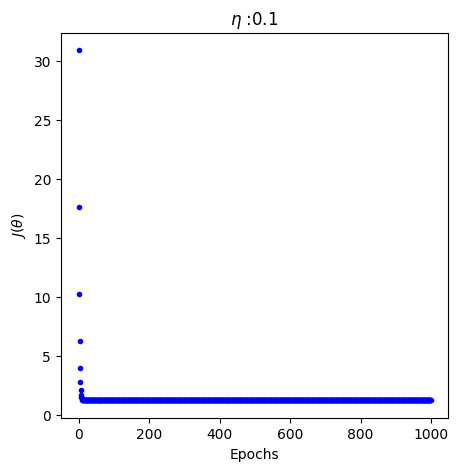

In [ ]:
plot_history(eta,epochs,cost_history)

In [ ]:
def plot_2D(theta,theta_history, epochs, pas=25):
    """
    Affichage en 2D de la cost_function
    Paramètres :
    Entrée :
    ----------------
    theta : array theta0 = theta[0], theta1 = theta[1]
    theta_history array : contient l'historique des thetas lors de l'apprentissage
    epochs int : epochs utilisés lors de l'apprentissage
    pas int : indique dans l'historique combien de points doivent être plotés
    """
    theta0_reel = theta[0]
    theta1_reel = theta[1]
    fig, ax = plt.subplots(figsize=(5,5))
    # x et y à tracer
    m=10
    x = np.linspace(-1,1,m)
    y = theta0_reel + theta1_reel * x

    #fonction plus simple qui calcule le coût pour les valeurs de l'affichage
    def cost_func(theta0, theta1):
        return np.average((y-(theta0 + theta1*x))**2, axis=2)/2

    # Construction de la grille
    # y_theta0=int(theta0_true+2) pour centrer le dessin idem pour y_theta1
    # nb_points = nombre de points de la courbe
    y_theta0=int(theta0_reel+3)
    y_theta1=int(theta1_reel+3)
    nb_points=100
    theta0_grid = np.linspace(-2,y_theta0,nb_points)
    theta1_grid = np.linspace(-2,y_theta1,nb_points)

    #recuperation de la cost function pour les differentes valeurs de theta0 et theta1
    #définie par les theta0_grid et theta1_grid

    J_grid = cost_func(theta0_grid[np.newaxis,:,np.newaxis],
                   theta1_grid[:,np.newaxis,np.newaxis])

    # Mise en place des courbes de niveau et du contour
    X, Y = np.meshgrid(theta0_grid, theta1_grid)
    contours = ax.contour(X, Y, J_grid, 30)
    ax.clabel(contours)
    ax.scatter([theta0_reel]*2,[theta1_reel]*2,s=[50,10], color=['b','r'])

    #selection des points à afficher ici tous les pas dans l'historique
    #on commence par 00 pour le sens des flêches
    thetas = [np.array((0,0))]
    N=1
    for i in range(epochs-1):
        if i % pas ==0:
            N+=1
            this_theta = np.empty((2,))
            this_theta=theta_history[i]
            thetas.append(this_theta)

    # fleches
    for i in range(1,N):
        ax.annotate('', xy=thetas[i], xytext=thetas[i-1],
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')

    ax.scatter(*zip(*thetas), c='b', s=40, lw=0)

    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_title('Cost function')

    plt.show()

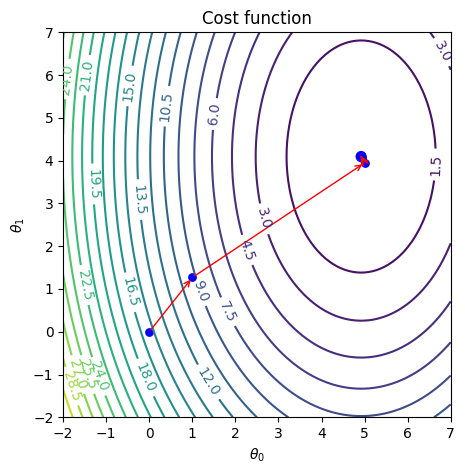

In [ ]:
#transformation en tableau pour theta0 et theta1
theta=[theta0,theta1]
plot_2D(theta,theta_history,epochs,pas=100)

In [ ]:
def plot_lines (eta,epochs,theta_history):
    tr =0.1
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel("$x$", fontsize=10)
    ax.set_ylabel("$y$", fontsize=10)
    ax.plot(X,y,'b.')
    for i in range (epochs):
        pred=predict(X, theta_history[i][0], theta_history[i][1])
        if ((i % 25 == 0) ):
            _ = ax.plot(X,pred,'r-',alpha=tr)
            if tr < 0.8:
                tr = tr+0.2


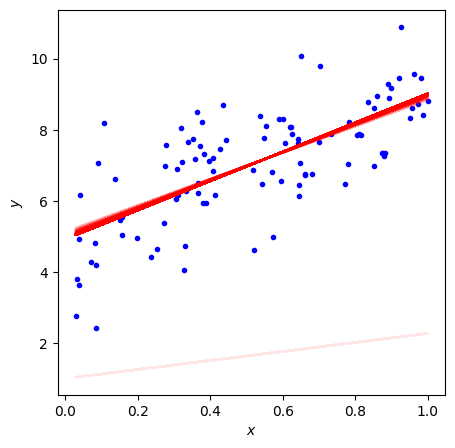

In [ ]:
plot_lines(eta,epochs,theta_history)

In [ ]:
def plot_all (eta,epochs,theta_history,ax,ax1):
    tr =0.1
    #fig,ax = plt.subplots(figsize=(5,5))
    ax1.plot(X,y,'b.')
    for i in range (epochs):
        pred=predict(X, theta_history[i][0], theta_history[i][1])
        if ((i % 25 == 0) ):
            ax1.plot(X,pred,'r-',alpha=tr)
            if tr < 0.8:
                tr = tr+0.2
    ax.plot(range(epochs),cost_history,'b.')

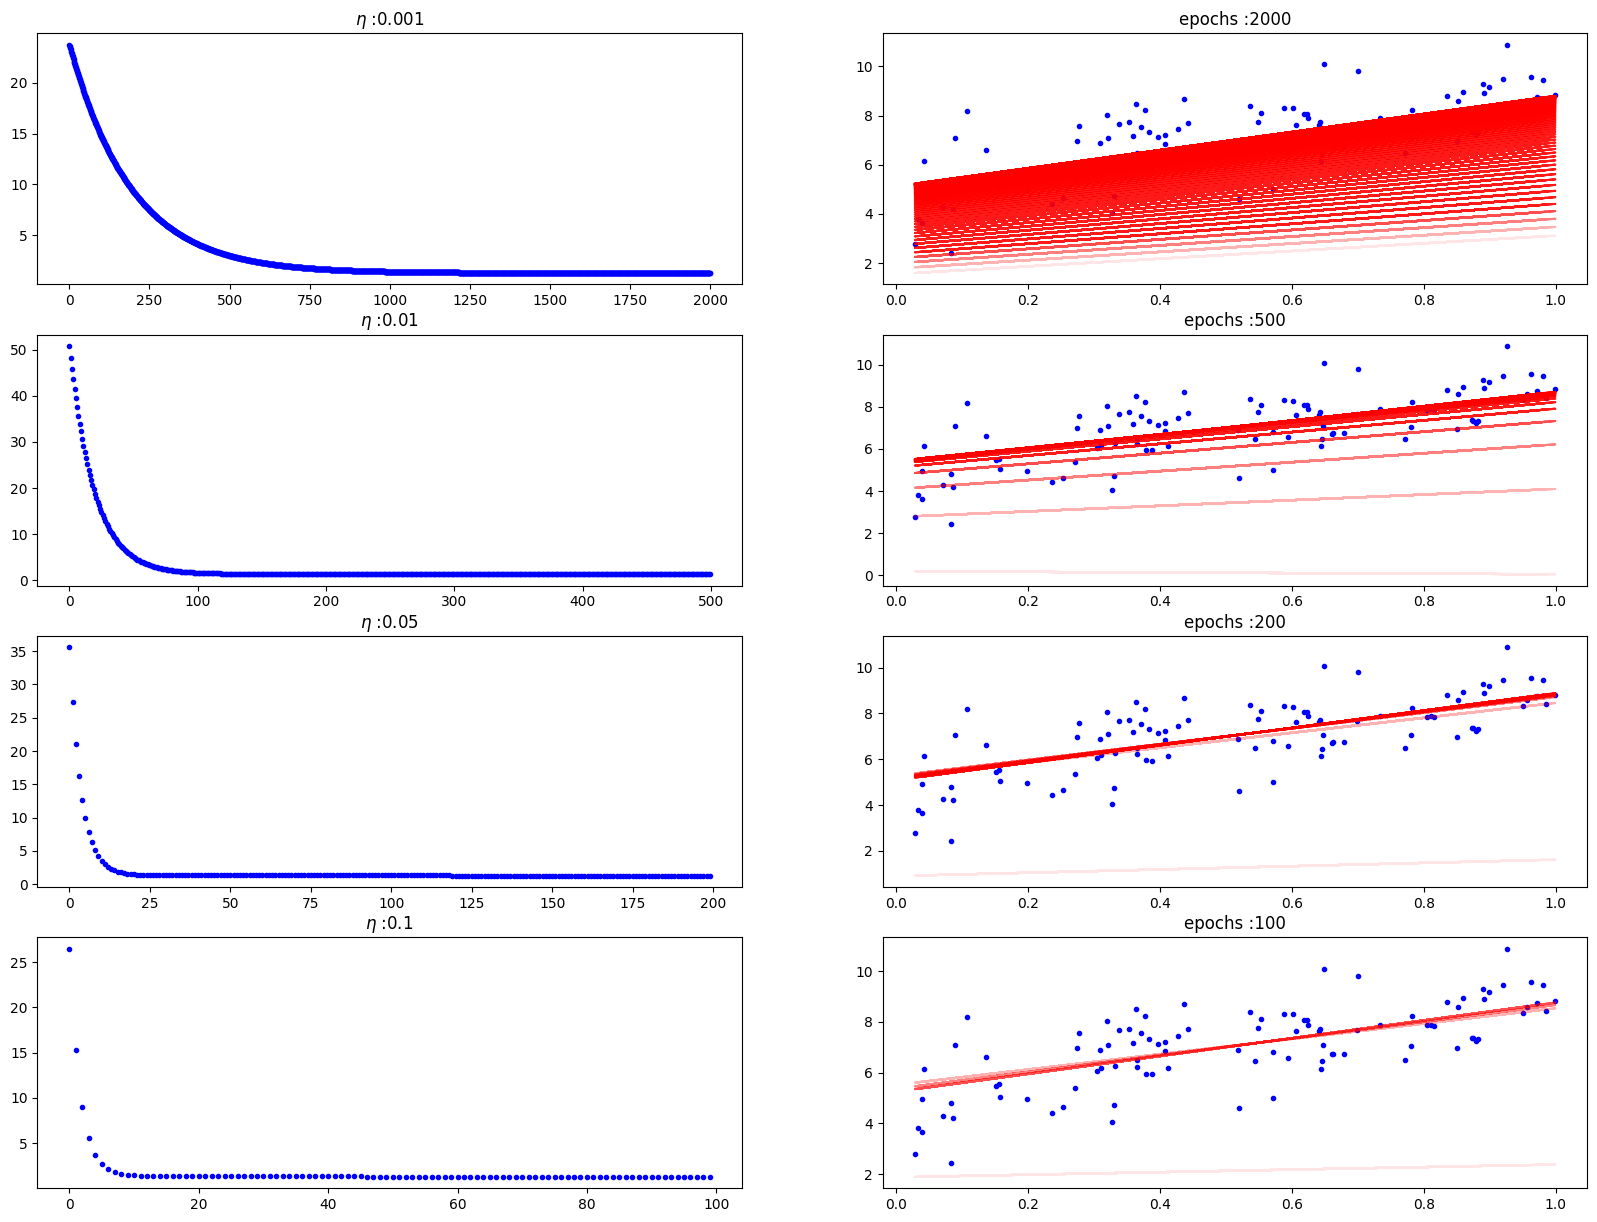

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
epochs_eta =[(2000,0.001),(500,0.01),(200,0.05),(100,0.1)]

count =0
for epochs, eta in epochs_eta:
    count += 1
    ax = fig.add_subplot(4,2,count)
    ax.set_title(r"$\eta$ :{}".format(eta))
    count += 1

    ax1 = fig.add_subplot(4,2,count)
    ax1.set_title("epochs :{}".format(epochs))


    theta0=np.random.randn()
    theta1=np.random.randn()

    theta0,theta1,cost_history,theta_history=gradient_descent(X, y,theta0, theta1, eta, epochs)
    plot_all(eta,epochs,theta_history,ax,ax1)



## Generalisation et regression linéaire multiple


Dans la section précédente nous avons vu les principes d'une regression linéaire simple. Dans cette section, nous étendons le principe à une régression linéaire multiple (*Multivariate Linear Regression*), i.e. ayant plusieurs paramètres. De plus nous présentons une manière plus efficace d'implémenter la descente de gradient à l'aide de matrice.  


Dans une regression linéaire simple on cherche à modéliser la relation entre deux variables quantitatives continues.
Comme nous l'avons vu précédemment un modèle de régression linéaire simple est de la forme
$h_\theta(x) = \theta_0 + \theta_1x$
où :
- $h_\theta(x)$ est le modèle/l'hypothèse pour la variable $y$ à prédire;
- $x$ est la variable prédictive;
- $\theta_0$ et $\theta_1$ les paramètres à estimer.

Plus formellement le modèle est plutôt de la forme $h_\theta(x) = \theta_0 + \theta_1x + \epsilon$ où $\epsilon$ correspond au terme d'erreur aléatoire du modèle. Dans notre cas nous le négligeons pour le moment.  

Dans une regression linéaire multiple on cherche à modéliser la relation entre plus de deux variables quantitatives continues. Un modèle de régression linéaire multiple est donc de la forme :

$$h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + ...+\theta_nx_n$$  


Par exemple pour connaître la concentration d'ozone dans l'air (y), il faut tenir compte de la température ($x_1$) et de la vitesse du vent ($x_2$).  

**Représentation sous la forme de matrice**  


Ce modèle peut tout à fait être représenté sous la forme de matrices (cette implémentation est beaucoup plus efficace que la précédente) et d'utiliser des produits scalaires entre matrices.

Pour cela il faut au préalable ajouter une colonne de 1 à la matrice des variable prédictives (le nombre de valeurs prédictives est donc incrémenté de 1). Ce 1 permet de pouvoir traiter en même temps que les autres le $\theta_0$, i.e. $h_\theta(x) = \theta_0x_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + ...+\theta_nx_n$.   
Avec $m$ le nombre d'enregistrements et $n$ le nombre de variables prédictives nous avons :

$$h_\theta(x) = \theta_0x_0+ \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + ...+\theta_nx_n \\
=\theta^TX$$  

où $\theta^T$ correspond à la transposée de la matrice $\theta$.

$$X=\begin{bmatrix}
1 & x_1^1 &  x_2^1 & \ldots&x_n^1\\
1 & x_1^2&  x_2^2& \ldots&x_n^2\\
1 & x_1^3&  x_2^3& \ldots&x_n^3\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_1^m & x_2^m& \ldots &x_n^m
\end{bmatrix} (taille : m \times n+1)$$

pour les $\theta$ :
$$\theta=\begin{bmatrix}
\theta_0\\
\theta_2\\
\theta_3\\
\vdots\\
\theta_n
\end{bmatrix} (taille : n+1 \times 1)$$


Et pour $y$, nous avons :
$$y=\begin{bmatrix}
y_1\\
y_2\\
y_3\\
\vdots\\
y_m
\end{bmatrix} (taille : m \times 1)$$

La prédiction peut donc, par exemple, facilement se faire par un simple produit scalaire :  
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/Predictionmatrice.png" width="330" height="190">
</center>
$$\begin{bmatrix}
y_1\\
y_2\\
y_3\\
\vdots\\
y_m
\end{bmatrix}=
\begin{bmatrix}
1 & x_1^1 &  x_2^1 & \ldots&x_n^1\\
1 & x_1^2&  x_2^2& \ldots&x_n^2\\
1 & x_1^3&  x_2^3& \ldots&x_n^3\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_1^m & x_2^m& \ldots &x_n^m
\end{bmatrix} \bullet
\begin{bmatrix}
\theta_0\\
\theta_2\\
\theta_3\\
\vdots\\
\theta_n
\end{bmatrix}$$  


$$\begin{bmatrix}
y_1\\
y_2\\
y_3\\
\vdots\\
y_m
\end{bmatrix}=
\begin{bmatrix}
\theta_0 & \theta_1x_1^1 &  x_2^1 & \ldots&\theta_nx_n^1\\
\theta_0 & \theta_1x_1^2&  x_2^2& \ldots&\theta_nx_n^2\\
\theta_0 & \theta_1x_1^3&  x_2^3& \ldots&\theta_nx_n^3\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
\theta_0 & \theta_1x_1^m & x_2^m& \ldots &\theta_nx_n^m
\end{bmatrix}$$  

La dérivée partielle par rapport à $\theta_j$ est maintenant :

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{-2}{m} \sum_{i=1}^m (h_\theta (x^{(i)})-y^{(i)})x_j^{(i)} $$  



L'algorithme de descente de gradient peut donc se généraliser en :

$$\begin {array} {lc}
Initialisation\ de\ \theta_j\ avec\ des\ nombres\ al\acute{e}atoires\\
R\acute{e}p\acute{e}ter\ jusqu'\grave{a}\ convergence \{ &  \\
&\theta_j = \theta_j - \eta  \frac{-2}{m} \sum_{i=1}^m (h_\theta x^{(i)})-y^{(i)})x_j^{(i)}\\
en\ mettant\ simultan\acute{e}ment\ \theta_j \ \grave{a}\ jour\ pour\ j=(1,\ldots,n)\\
\}
\end{array}
$$   

ce qui donne :
$$\theta_0 = \theta_0 - \eta  \frac{-2}{m} \sum_{i=1}^m (h_\theta x^{(i)})-y^{(i)})x_0^{(i)}\ avec x_0^{(i)}=1\\
\theta_1 = \theta_1 - \eta  \frac{-2}{m} \sum_{i=1}^m (h_\theta x^{(i)})-y^{(i)})x_1^{(i)}\\
\theta_2 = \theta_2 - \eta  \frac{-2}{m} \sum_{i=1}^m (h_\theta x^{(i)})-y^{(i)})x_2^{(i)}\\
\vdots
$$

ou tout simplement :

$$\begin {array} {lc}
Initialisation\ de\ \theta_j\ avec\ des\ nombres\ al\acute{e}atoires\\
R\acute{e}p\acute{e}ter\ jusqu'\grave{a}\ convergence \{ &  \\
&\theta = \theta - \eta  \frac{-2}{m} (X \bullet \theta-y)X^T\\
\}
\end{array}
$$   




In [ ]:
matrice=np.random.randint(10, size=(2, 3))
print ("une matrice\n",matrice)
print ("la transposée de la matrice\n",matrice.T)

une matrice
 [[6 8 3]
 [5 7 1]]
la transposée de la matrice
 [[6 5]
 [8 7]
 [3 1]]


### Implémentation



Nous définissons d'abord la fonction predict

In [ ]:
def predict(X, theta):
    """
    Prediction de la valeur de X
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives)
    theta array : theta[0], theta1 = theta[1]
    ----------------
    Output :
    array correspondant au produit matricielle de X avec les thetas
    """
    return X.dot(theta)

La fonction de coût se fait simplement à l'aide d'un produit scalaire (fonction dot en python)

In [ ]:
def cost_function(X,y,theta):
    """
    Calcul de la fonction de coût
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives)
    y array : données d'apprentissage (valeur à prédire)
    theta array : theta[0], theta1 = theta[1]
    ----------------
    Output :
    MSE
    """

    m=len(y)
    prediction=X.dot(theta)
    square_err=(prediction - y)**2
    return 1/(2*m) * np.sum(square_err)

La descente de gradient (ne pas oublier la transposé de X)

In [ ]:
def gradient_descent(X,y,theta,eta=0.01, epochs=1000):
    """
    Descente de gradient simple (vanilla descent gradient)
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives)
    y array : données d'apprentissage (valeur à prédire)
    theta array : theta[0], theta1 = theta[1]
    eta float : le learning rate
    epochs int : nombre de répétitions
    ----------------
    Output :
    theta array : theta[0], theta1 = theta[1]
    cost_history array : liste du coût de theta à chaque itération
    theta_history array : liste des thetas à chaque itération
    """

    m=len(y) # attention prendre y et non x car il y a un entier en plus
    cost_history=[]
    theta_history = np.zeros((epochs,2),dtype=float)
    #Attention theta_history est pour afficher en 2D donc vecteur à 2 dimensions

    for i in range(epochs):

        #Le code ci-dessous peut s'écrire en une ligne
        #theta = theta -(1/(2*m))*eta*( X.T.dot((prediction - y)))
        prediction = predict(X,theta)
        error = X.T.dot((prediction - y))
        descent=eta * (1/(2*m)) * error
        theta-=descent

        #pour affichage
        theta_history[i][0]=theta[0]
        theta_history[i][1]=theta[1]
        cost_history.append(cost_function(X,y,theta))

    return theta, cost_history, theta_history

In [ ]:
eta =0.01
epochs = 2000
#initialisation aléatoire de theta0 et de theta1
# dans cette exemple on considère une fonction du type
# theta0 + theta1x_1 pour l'affichage en 2D elle est bien sûr généralisable
theta = np.random.randn(2,1)
X = np.random.rand(100,1)
y = 5 + 4*X+np.random.randn(100,1)

#X_0 ajoute un 1 au début de X pour avoir : theta0x_0 + theta1x_1 ...
X_0 = np.c_[np.ones((X.shape[0])), X]


#appel de la fonction attention c'est avec X_0
theta,cost_history,theta_history = gradient_descent(X_0,y,theta,eta,epochs)
print ('theta0 = %0.2f'%theta[0],' theta1 = %.2f'%theta[1],' cost(%0.2f)'%cost_history[-1])


theta0 = 5.69  theta1 = 2.71  cost(0.53)


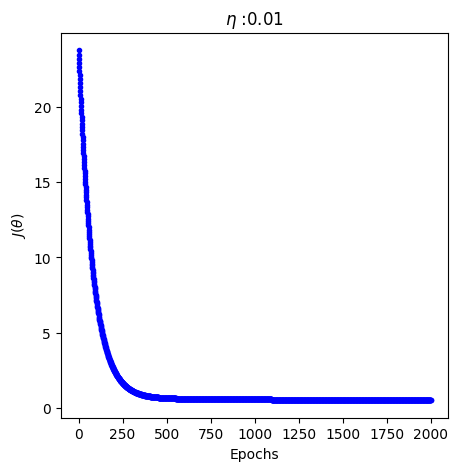

In [ ]:
plot_history(eta,epochs,cost_history)

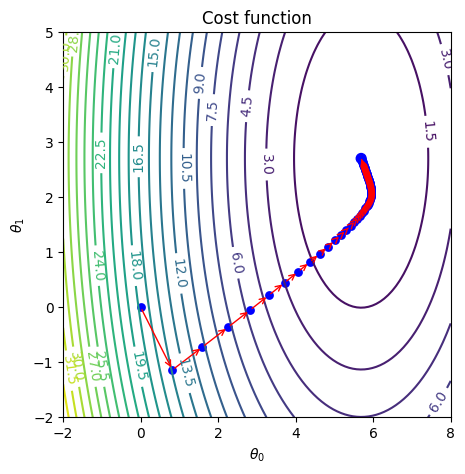

In [ ]:
plot_2D(theta,theta_history,epochs,pas=25)

## Optimisation : différentes stratégies

L'algorithme de descente de gradient que nous avons vu précédemment est également appelée descente de gradient par lots (*Batch Gradient Descent*) et est le plus simple : il calcule l'erreur pour chaque exemple dans l'ensemble d'apprentissage. Après avoir évalué tous les enregistrements de l'ensemble d'apprentissage (1 epoch), il met à jour les paramètres du modèle.   

Il présente l’avantage d’être assez efficace en termes de calcul et de produire un gradient d’erreur stable et une convergence stable. L'un des inconvénients est que ce gradient d’erreur stable peut parfois conduire à un état de convergence qui n’est pas optimal. L'autre inconvénient (important) est aussi qu'il nécessite que l'ensembe du jeu de données d'apprentissage réside en mémoire et ce n'est pas possible pour des jeux de données volumineux.  


Pour cela différentes stratégies ont été proposées.

**Stochastic gradient descent**

La descente de gradient stochastique (*Stochastic Gradient Descent*) met à jour les paramètres en fonction du gradient de l'erreur par rapport à un seul exemple d'apprentissage (batch_size=1) tiré aléatoirement (d'où le terme stochastique) même s'il est tout à fait possible de considérer un sous ensemble d'exemples. Ceci est différent de Batch Gradient Descent, qui met à jour les paramètres une fois que tous les exemples d'apprentissage ont été évalués.

Il ne consomme pas beaucoup de mémoire et est souvent plus rapide car un seul échantillon est traité à la fois.  Ainsi pour des grands ensembles de données, la convergence peut être plus rapide car les mises à jour des paramètres sont plus fréquentes. L'avantage de ces mises à jour fréquentes est que les étapes effectuées vers les minima de la fonction de perte ont des oscillations qui peuvent aider à sortir des minimums locaux.


En fonction des données, elle est généralement plus rapide que la descente de gradient par lots. Cependant il s'avère qu'à cause des mises à jour fréquentes la convergence prenne plus de temps (descente dans des directions différentes). Les mises à jour fréquentes sont coûteuses en termes de calcul car elles utilisent toutes les ressources pour traiter un échantillon d'apprentissage à la fois.
Enfin, quand il y a un seul exemple, nous perdons tous les avantages de l'utilisation des matrices.

**Implémentation du Stochastique Gradient Descent**  

Dans la boucle principale (epoch), lors du parcours du jeu d'apprentissage, un nombre aléatoire d'exemples sont choisis et le calcul se fait sur eux.

In [ ]:
def stocashtic_gradient_descent(X,y,theta,learning_rate=0.01,epochs=1000):
    """
    Descente de gradient stochastique
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives) avec un 1 ajouté au début
    y array : données d'apprentissage (valeur à prédire)
    theta array : theta[0], theta1 = theta[1]
    eta float : le learning rate
    epochs int : nombre de répétitions
    ----------------
    Output :
    theta array : theta[0], theta1 = theta[1]
    cost_history array : liste du coût de theta à chaque itération
    theta_history array : liste des thetas à chaque itération
    """

    m=len(y)
    cost_history=[]
    theta_history = np.zeros((epochs,2),dtype=float)
    for i in range(epochs):
        cost = 0.0
        for j in range(m):
            #tirage d'un nombre aléatoire entre 0 et m
            rand_ind = np.random.randint(0,m)
            #recuperation du X et y correspondants au nombre aléatoire
            X_j = X[rand_ind,:].reshape(1,X.shape[1])
            y_j = y[rand_ind].reshape(1,1)
            prediction = predict(X_j,theta)
            error = X_j.T.dot((prediction - y_j))
            descent=eta * (1/(2*m)) * error
            theta-=descent
        cost+=cost_function(X_j,y_j,theta)

        theta_history[i][0]=theta[0]
        theta_history[i][1]=theta[1]
        cost_history.append(cost)
    return theta, cost_history, theta_history

In [ ]:
eta =0.01
epochs = 2000
#initialisation aléatoire de theta0 et de theta1
theta = np.random.randn(2,1)
X = np.random.rand(100,1)
y = 5 + 4*X+np.random.randn(100,1)

#X_0 ajoute un 1 au début de X pour avoir : theta0x_0 + theta1x_1 ...
X_0 = np.c_[np.ones((X.shape[0])), X]

theta,history_stoc,theta_history = stocashtic_gradient_descent(X_0,y,theta,eta,epochs)
print ('theta0 = %0.2f'%theta[0],' theta1 = %.2f'%theta[1],' cost(%0.2f)'%history_stoc[-1])

theta0 = 5.28  theta1 = 3.36  cost(0.76)


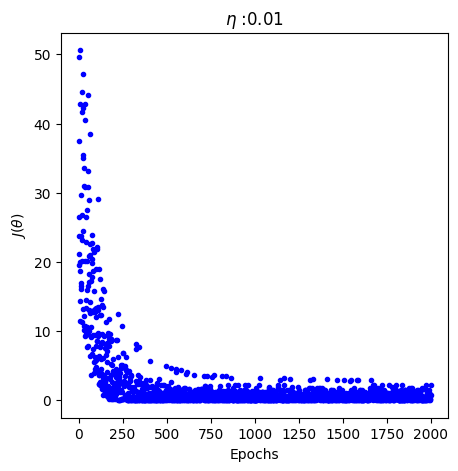

In [ ]:
plot_history(eta,epochs,history_stoc)

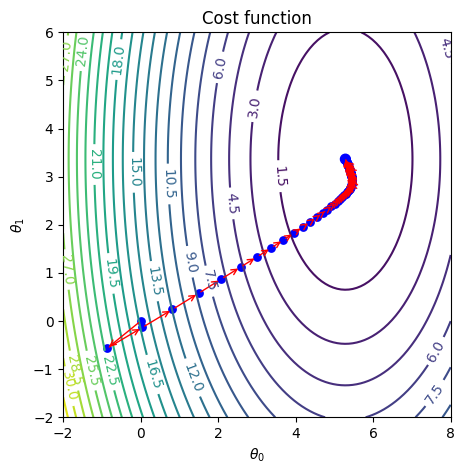

In [ ]:
plot_2D(theta,theta_history,epochs,pas=25)

**Mini-batch gradient descent**  


L'algorithme de descente de gradient par mini lots (*mini-batch gradient descent*) est souvent privilégié, car il associe une descente en gradient stochastique et une descente en gradient par lots. Il sépare simplement le jeu d'apprentissage en petits lots et effectue une mise à jour pour chacun de ces lots. Cela crée donc un équilibre entre l'efficacité de la descente de gradient par lots et la robustesse de la descente de gradient stochastique. Il est très utilisé en apprentissage profond (deep learning).

**Implémentation du Mini-batch gradient descent**  

Le jeu d'apprentissage est découpé en petit batch en tirant des valeurs d'exemple au hasard. Ensuite chaque batch est examiné par la descente de gradient.

In [ ]:
def next_batch(X, y, batchsize):
    """
    Création des batches
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives) avec un 1 ajouté au début
    y array : données d'apprentissage (valeur à prédire)
    batchsize int : taille du batch
    """
    m=len(y)
    # permutation aléatoire de X et y pour faire des batchs avec des valeurs au hasard
    indices = np.random.permutation(m)
    X = X[indices]
    y = y[indices]
    for i in np.arange(0, X.shape[0], batchsize):
        # creation des batchs de taille batchsize
        yield (X[i:i + batchsize], y[i:i + batchsize])

In [ ]:
def minibatch_gradient_descent(X,y,theta,learning_rate=0.01,epochs=10,batchsize=64):
    """
    Descente de gradient par mini batch
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives) avec un 1 ajouté au début
    y array : données d'apprentissage (valeur à prédire)
    theta array : theta[0], theta1 = theta[1]
    eta float : le learning rate
    epochs int : nombre de répétitions
    batchsize int : taille du batch
    ----------------
    Output :
    theta array : theta[0], theta1 = theta[1]
    cost_history array : liste du coût de theta à chaque itération
    theta_history array : liste des thetas à chaque itération
    """
    m=len(y)
    cost_history=[]
    theta_history = np.zeros((epochs,2),dtype=float)
    for i in range(epochs):
        cost_batch = []
        for (batchX, batchY) in next_batch(X, y, batchsize):
            # Extraction et traitement d'un batch à la fois
            prediction = predict(batchX,theta)
            error = batchX.T.dot((prediction - batchY))
            descent=eta * (1/(2*m)) * error
            theta-=descent
            cost_batch.append(cost_function(batchX,batchY,theta))
            theta_history[i][0]=theta[0]
            theta_history[i][1]=theta[1]

        cost_history.append(np.average(cost_batch))

    return theta, cost_history, theta_history


In [ ]:
eta =0.1
epochs = 2000
#initialisation aléatoire de theta0 et de theta1
theta = np.random.randn(2,1)
X = np.random.rand(100,1)
y = 5 + 4*X+np.random.randn(100,1)

#X_0 ajoute un 1 au début de X pour avoir : theta0x_0 + theta1x_1 ...
X_0 = np.c_[np.ones((X.shape[0])), X]

theta,history_mini,theta_history = minibatch_gradient_descent(X_0,y,theta,eta,epochs)
print ('theta0 = %0.2f'%theta[0],' theta1 = %.2f'%theta[1],' cost(%0.2f)'%history_mini[-1])

theta0 = 5.32  theta1 = 3.37  cost(0.46)


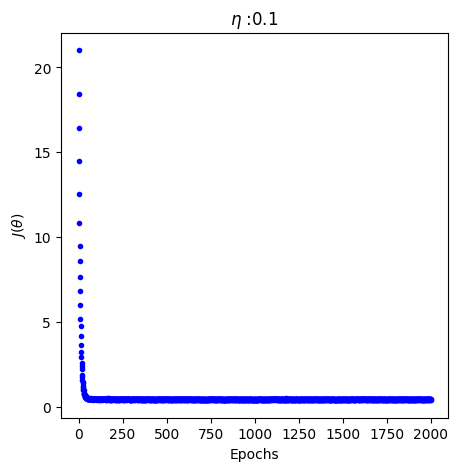

In [ ]:
plot_history(eta,epochs,history_mini)

**Momentum**

Les approches précédentes ont du mal dans les zones où la surface s’incline beaucoup plus fortement dans une dimension que dans une autre. Dans ces scénarios, la descente de gradient  oscille sur les pentes et ne progresse que doucement vers le minima local.
Momentum est une méthode qui permet d’accélérer la descente de gradient dans la direction voulue et d’atténuer les oscillations (C.f Figure).
<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/Momentum.png" width="550" height="300">
</center>

Le principe est le suivant. Considérons une balle qui descend le long d'une colline. Elle accumule de l'élan (*Momentum*) dans la descente et devient de plus en plus rapide jusqu'à ce qu'elle atteigne sa vitesse limite s'il existe une résistance de l'air. Dans le cas de la mise à jour des paramètres, la quantité de mouvement augmente pour les dimensions dont les gradients pointent dans la même direction et réduit les mises à jour pour les dimensions dont les gradients changent de direction. Par conséquent la convergence est plus rapide car le nombre d'oscillation diminue.


Momentum permet de modifier la descente de gradient en introduisant deux nouveaux paramètres : la vitesse $v$ que nous essayons d'optimiser et le frottement ($\beta$).

Formellement il est défini, pour une fonction de coût $J$ quelconque, de la manière suivante :  

$$v=\beta v - \eta \Delta J $$
$$\theta = \theta - v$$

Dans le cas des fonctions linéaires précédentes nous avons :  


$$v=\beta v-\eta \times \frac{-2}{m} \times (X \bullet \theta-y)X^T$$
$$\theta = \theta - v$$  


L’avantage de momentum est qu'il ne change pas beaucoup l'algorithme de descente de gradient mais qu'il accélère considérablement l'apprentissage. Généralement $\beta$ est fixé à 0.9.

**Implémentation du momentum**  

L'approche par mini-batch étant la plus efficace, il suffit de remplacer la partie mise à jour des gradients par la formule précédente.

In [ ]:
def next_batch(X, y, batchsize):
    """
    Création des batches
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives) avec un 1 ajouté au début
    y array : données d'apprentissage (valeur à prédire)
    batchsize int : taille du batch
    """
    m=len(y)
    # permutation aléatoire de X et y pour faire des batchs avec des valeurs au hasard
    indices = np.random.permutation(m)
    X = X[indices]
    y = y[indices]
    for i in np.arange(0, X.shape[0], batchsize):
        # creation des batchs de taille batchsize
        yield (X[i:i + batchsize], y[i:i + batchsize])

In [ ]:
def minibatch_gradient_descent_Momentum(X,y,v,beta,theta,learning_rate=0.01,epochs=10,batchsize=64):
    """
    Descente de gradient par mini batch avec momentum
    Paramètres :
    ----------------
    Input :
    X array : données d'apprentissage (variables prédictives) avec un 1 ajouté au début
    y array : données d'apprentissage (valeur à prédire)
    theta array : theta[0], theta1 = theta[1]
    eta float : le learning rate
    epochs int : nombre de répétitions
    batchsize int : taille du batch
    beta : momentum
    ----------------
    Output :
    theta array : theta[0], theta1 = theta[1]
    cost_history array : liste du coût de theta à chaque itération
    theta_history array : liste des thetas à chaque itération
    """
    m=len(y)
    cost_history=[]
    v_history=np.zeros((epochs,2),dtype=float)
    theta_history = np.zeros((epochs,2),dtype=float)

    #beta=0.9
    for i in range(epochs):
        cost_batch = []
        for (batchX, batchY) in next_batch(X, y, batchsize):
            # Extraction et traitement d'un batch à la fois
            prediction = predict(batchX,theta)
            error = batchX.T.dot((prediction - batchY))
            # calcul du momentum
            grad=(1/(2*m)) * error
            v = beta * v + eta*grad
            theta-= v
            cost_batch.append(cost_function(batchX,batchY,theta))
            theta_history[i][0]=theta[0]
            theta_history[i][1]=theta[1]

        cost_history.append(np.average(cost_batch))

    return theta, cost_history, theta_history



In [ ]:
eta =0.1
epochs = 2000
beta = 0.9 # frottement
#initialisation aléatoire de theta0 et de theta1
theta = np.random.randn(2,1)
X = np.random.rand(100,1)
y = 5 + 4*X+np.random.randn(100,1)
# ajout du vecteur de vitesse
v = np.zeros(shape=(2,1))
#X_0 ajoute un 1 au début de X pour avoir : theta0x_0 + theta1x_1 ...
X_0 = np.c_[np.ones((X.shape[0])), X]

theta,history_minimomentum,theta_history = minibatch_gradient_descent_Momentum(X_0,y,v,beta,theta,eta,epochs)
print ('theta0 = %0.2f'%theta[0],' theta1 = %.2f'%theta[1],' cost(%0.2f)'%history_mini[-1])

theta0 = 4.88  theta1 = 4.03  cost(0.46)


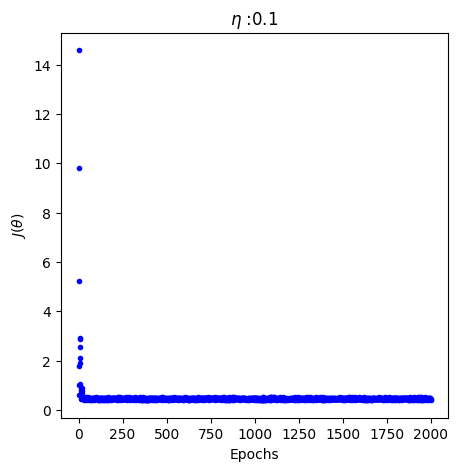

In [ ]:
plot_history(eta,epochs,history_minimomentum)


Il existe d'autres types d'optimisation :  
- *Nesterov Momentum* assez proche de Momentum mais qui, au lieu de calculer le gradient à la position actuelle, le calcul à une nouvelle position approximé.
- *Adagrad* s'intéresse au learning rate. Précédemment $\eta$ a toujours été considéré constant. L'objectif d'Adagrad est de s'adapter pour pouvoir accélérer ou ralentir.
- *RMSprop* est une extension d'Adagrad pour corriger le fait que ce dernier considère une fonction d'accumulation du gradient qui est croissante monotone. Ceci peut cependant poser des problèmes car le taux d'apprentissage diminue également de façon monotone et l'apprentissage peut s'arrêter car $\eta$ devient trop petit.
- *ADAM* cumule les avantages de Momentum et de RMSprop.

Toutes ces optimisations sont disponibles dans la plupart des approches de deep learning et sont utilisées lors des étapes de backpropagation.

## Un exemple d'utilisation : la regression logistique

La régression logistique (*Logistic regression*) ou modèle logit constitue un cas particulier de modèle linéaire généralisé et est particulièrement utilisé comme approche supervisée de classification. Par contre, contrairement au modèle linéaire, la variable prédite ne peut prendre qu'un nombre limité de valeurs.


Dans le cas de la régression logistique binaire, étant donné un ensemble d'entrées X, l'objectif est de les classer dans l'une des deux catégories possible : 0 ou 1. En d'autres termes, elle modélise la probabilité que chaque entrée appartienne à une catégorie particulière.

Dans notre cas, nous savons que le modèle de regréssion linéaire est de la forme :

$$h_\theta(x)=\theta^Tx$$

Pour pouvoir effectuer la classication, nous devons appliquer une fonction :
$$h_\theta(x)=\sigma(\theta^Tx)$$

Dans le cas binaire, l'une des fonction d'activation couramment utilisée est la fonction sigmoide $$\sigma(t) = \frac{1}{1 + e^{-t}}$$

L'hypothèse pour la regression logistique devient donc :
'$$h_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}$$



In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

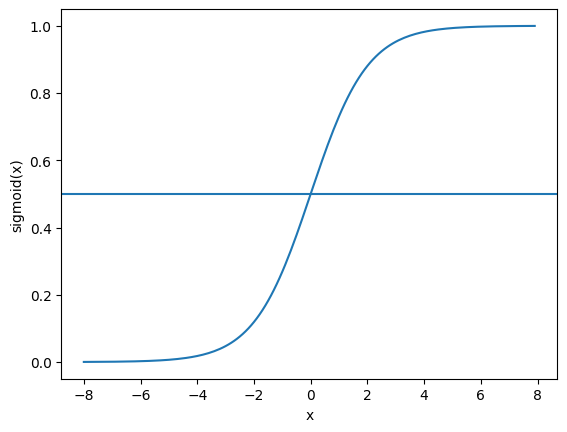

In [ ]:
x = np.arange(-8, 8, 0.1)
f = sigmoid(x)
plt.plot(x, f)
plt.xlabel('x')
plt.axhline(.5)
plt.ylabel('sigmoid(x)')
plt.show()


Nous remarquons sur la courbe que sigmoid($x$) > 0.5 quand $x$ > 0 et sigmoid ($x$) < 0.5 quand $x$ < 0 :  

$$h_\theta(x)=\left\{\begin{array}{l}
>0.5,\ si\ \theta^Tx >0\\
<0.5,\ si\ \theta^Tx <0
\end{array}
\right.$$

En d'autres termes, si la somme pondérée des entrées est supérieure à zéro, la classe prédite est 1 et inversement si elle est inférieure à 0, la classe prédite est 0.

La fonction de coût généralement associée est la suivante :  

$$Cost=\left\{\begin{array}{l}
-log(h_\theta(x)),\ si\ y=1\\
-log(1-h_\theta(x)),\ si\ y=0
\end{array}
\right.$$

L'intuition derrière la fonction de coût est la suivante :  

Si la classe réelle est 1 et que le modèle prédit 0, il faut fortement le pénaliser et vice-versa. Comme vous pouvez le constater sur la figure ci-dessous, pour le graphique $-log (h_\theta  (x))$, lorsque $h_\theta  (x)$ approche de 1, le coût est égal à 0 et lorsque $h_\theta (x)$ est proche de 0, le coût est égal à l'infini (le modèle est fortement pénalisé). De même pour le graphique $-log (1-h_\theta (x))$ lorsque la valeur réelle est 0 et que le modèle prédit 0, le coût est 0 et le coût devient l'infini lorsque $h_\theta  (x)$ se rapproche de 1.

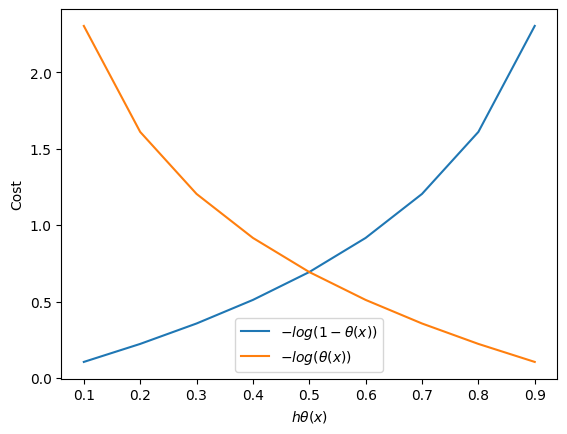

In [ ]:
x = np.arange(0.1, 1, 0.1)
f = -np.log(x)
g = -np.log(1-x)
plt.plot(x, g,label=r'$-log(1-\theta(x))$')
plt.plot(x, f,label=r'$-log(\theta(x))$')
plt.xlabel(r'$h\theta(x)$')
#plt.xlabel(r'$h_\theta(x)$')
plt.ylabel('Cost')
plt.legend()
plt.show()

Nous pouvons donc combiner les deux équations précédentes :   

$$Cost(h_\theta(x),y)=-ylog(h_\theta(x)-(1-y)log(1-h_\theta(x))$$

La perte pour tous les exemples d'apprentissage, $m$, est comme précédemment calculé en prenant la moyenne de tous les coûts de tous les échantillons d'apprentissage :   
$$J(\theta)=\frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}log(h_\theta(x^{(i)})-(1-y^{(i)})log(1-h_\theta(x^{(i)}))]$$

ou

$$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(h_\theta(x^{(i)})+(1-y^{(i)})log(1-h_\theta(x^{(i)}))]$$


La dérivée partielle par rapport à $\theta_j$ est  :

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta (x^{(i)})-y)x_j^{(i)} $$  

La descente de gradient consiste donc à répéter, comme précédemment, jusqu'à convergence :

$$\theta_j = \theta_j -\eta \frac{1}{m}X^T(\sigma(X.\theta) - y)$$

In [ ]:
def cost_function(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

Sélection du jeu de données Iris et récupération des 100 premiers enregistrements (*Serosa* et *Versicolor*). Nous nous intéressons uniquement aux deux premiers attributs (*longueur des sépales* et *largeur des sépales*).

In [ ]:
data = datasets.load_iris()

#recupération des 100 premiers (ils sont ordonnés)
X = data.data[:100, :2]
y = data.target[:100]


Affichage du jeu de données

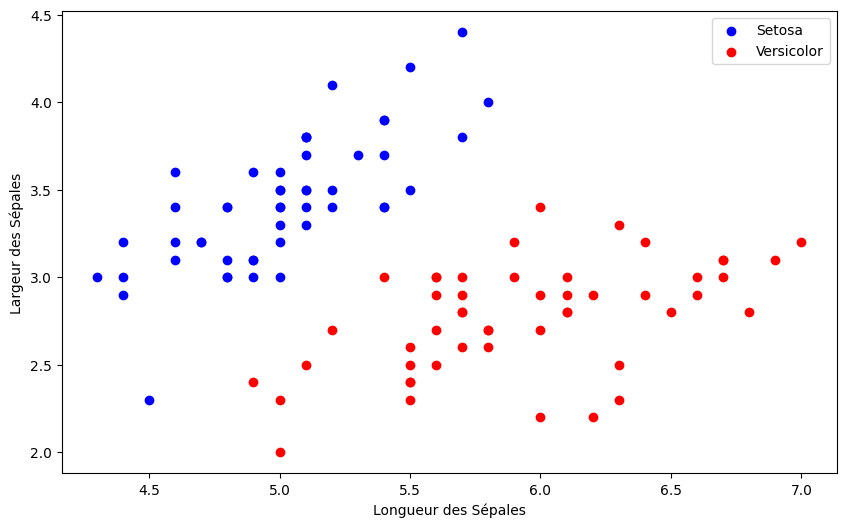

In [ ]:
plt.figure(figsize=(10, 6))
setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:,0], X[50:,1], c='r')
plt.xlabel("Longueur des Sépales")
plt.ylabel("Largeur des Sépales")
plt.legend((setosa, versicolor), ("Setosa", "Versicolor"))

In [ ]:
def gradient_descent(X, y,theta, eta=0.01, epochs=1000):
    m=len(y)
    cost_history=[]
    for i in range(epochs):
        z = np.dot(X,theta)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / m
        theta -= eta * gradient

        cost_history.append(cost_function(h,y))

    return theta, cost_history

In [ ]:
eta =0.1
epochs = 30000
#Initialisation de theta (ici à zéro)
theta = np.zeros(X.shape[1])

theta,cost_history=gradient_descent(X, y,theta, eta, epochs)

print ("Les paramètres sont : ",theta)

Les paramètres sont :  [  6.66602804 -11.67484425]


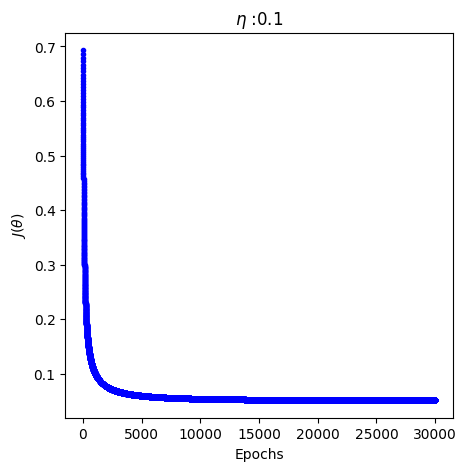

In [ ]:
plot_history(eta,epochs,cost_history)

Définissons, à présent, la fonction de prediction. Par rapport ce que nous avons vu précédemment, la valeur de seuil pour sigmoide est de 0.5.

In [ ]:
def predicts(X, theta, threshold=0.5):
    return sigmoid(np.dot(X, theta)) >= threshold

In [ ]:
y_predits = predicts(X,theta)
print (theta)
preds = predicts(X,theta)
(preds == y).mean()
print ("Nombre de bons prédits",np.sum(y == y_predits),' sur ',y.size)

[  6.66602804 -11.67484425]
Nombre de bons prédits 99  sur  100


Affichage de la zone de décision

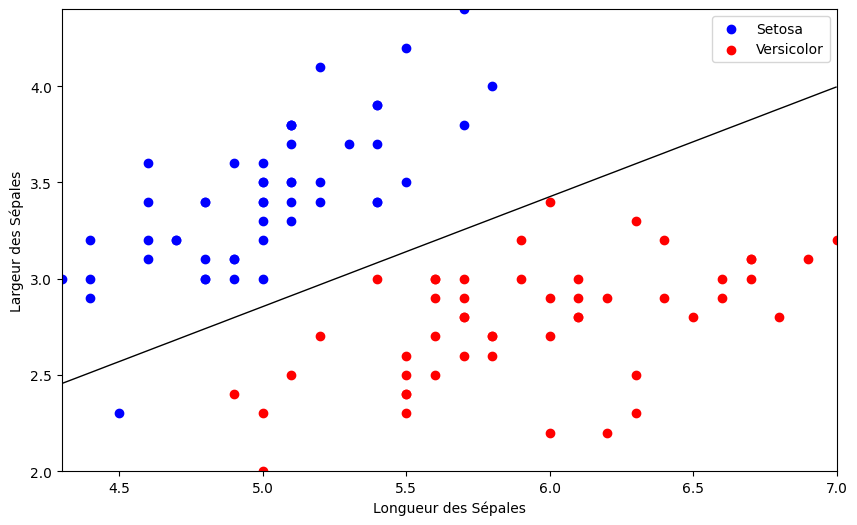

In [ ]:
plt.figure(figsize=(10, 6))
setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:,0], X[50:,1], c='r')
plt.xlabel("Longueur des Sépales")
plt.ylabel("Largeur des Sépales")
plt.legend((setosa, versicolor), ("Setosa", "Versicolor"))


x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = sigmoid(np.dot(grid, theta)).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');

Essayons à présent le modèle de Regression Logistique de Sickit Learn.

In [ ]:
clf = linear_model.LogisticRegression(solver='lbfgs')
clf.fit(X, y)
print ("Nombre de bons prédits avec Sickit Learn : ",np.sum(y == clf.predict(X)),' sur ',y.size)

Nombre de bons prédits avec Sickit Learn :  100  sur  100


Pas mal du tout !  


**Conclusion**
  
**Attention dans les exemples précédents nous n'avons pas normalisé les données. Avant toute opération il est indispensable de le faire !**  
  
Outre le fait qu'il puisse y avoir des données avec des valeurs très différentes, le fait de normaliser permet surtout de converger plus vite. Par exemple en utilisant la fonction suivante :  



In [ ]:
normalized_X = preprocessing.normalize(X)

Considérez la figure suivante. Précédemment nous avons vu qu'il fallait ajouter un 1 dans la première colonne de la matrice. Dans la figure ce $x_O$ s'appelle le biais. Si nous appelons $\sigma$, la fonction de sortie, fonction d'activation, nous obtenons un perceptron qui est la base des algorithmes de réseaux de neurones ... et donc de l'apprentissage profond. La regression logistique ne vise pas le même objectif que les réseaux de neurones car il s'agit de déterminer dans le premier cas une probabilité sur la valeur de sortie et dans le second cas il constitue une étape vers d'autres couches éventuelles mais comme vous pouvez le constater la construction est très similaire, les $\theta$ qui correspondent à nos paramètres sont généralement appelés *poids* dans les réseaux de neurones mais il s'agit de la même chose.

<center>
<img src="https://www.lirmm.fr/~poncelet/Ressources/FonctionActivation_biais2.png" width="350" height="350">
</center>
